In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.data import horse
import numpy as np
import skimage.data
from skimage.data import text

# 한글 시각화
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# <span style="color:skyblue"> 3. 이미지 컨투어 </span>

- `컨투어(contour)` : 동일한 색, 픽셀값을 가지고 있는 영역의 경계선 정보
    
    - 물체의 윤곽선, 외형을 파악하는데 사용됨

    - 윤곽선을 추출하기 위해 이미지의 이진화 과정이 필요함

- cv2.findContours() 함수 사용

```python
contours, hierachy  = cv2.findContours(image, mode, method)
```

- image : 흑백이미지 또는 이진화된 이미지

- mode : 컨투어를 찾는 방법
    > cv2.RETR_EXTERNAL, cv2.RETR_LIST, cv2.RETR_CCOMP, cv2.RETR_TREE

- method : 컨투어를 찾을 때 사용하는 근사화 방법
    > cv2.CHAIN_APPROX_NONE, cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_TC89_L1, cv2.CHAIN_APPROX_TC89_KCOS

In [38]:
# 이미지 불러오기
img_raw = horse().astype('uint8')
img_raw = np.ones(img_raw.shape) - img_raw
img = img_raw.copy().astype('uint8')

# 이미지의 컨투어 정보 출력
contours, hierachy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)

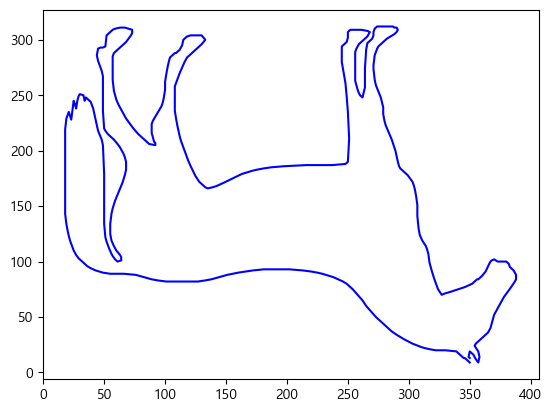

In [39]:
# 컨투어 시각화
x0, y0 = zip(*np.squeeze(contours[0]))
plt.plot(x0, y0, c="blue")
plt.show()

컨투어의 면적 : 42355.0


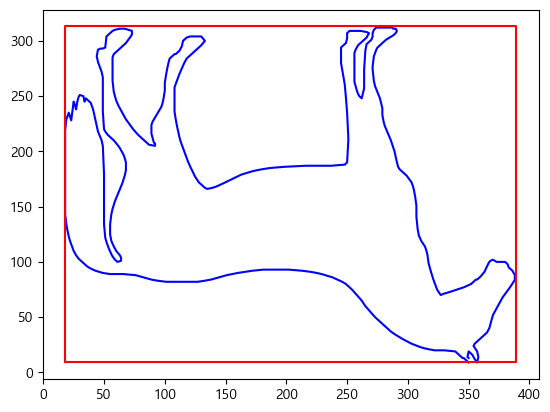

In [40]:
# 컨투어의 면적
print(f"컨투어의 면적 : {cv2.contourArea(contours[0])}")

# 컨투어를 둘러싸는 박스
x, y, w, h = cv2.boundingRect(contours[0])

plt.plot(x0, y0, c="b")
plt.plot(
    [x, x + w, x + w, x, x], 
    [y, y, y + h, y + h, y],
    c="r"
)
plt.show()

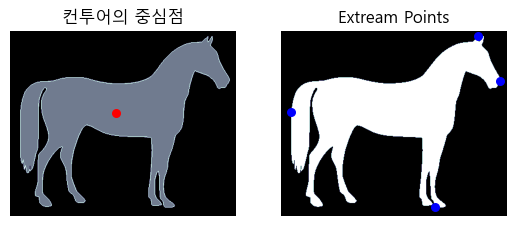

In [41]:
c0 = contours[0]
M = cv2.moments(c0)
image = cv2.drawContours(img, contours, 0, 2)

# 컨투어 라인의 중심점
cx = int(M['m10'] / M['m00'])
cy = int(M['m01'] / M['m00'])

# 컨투어 라인의 좌우상하 끝점
leftmost = tuple(c0[c0[:, :, 0].argmin()][0])
rightmost = tuple(c0[c0[:, :, 0].argmax()][0])
topmost = tuple(c0[c0[:, :, 1].argmin()][0])
bottommost = tuple(c0[c0[:, :, 1].argmax()][0])

# 중심점 시각화
plt.subplot(1,2,1)
plt.imshow(image, cmap='bone')
plt.title("컨투어의 중심점")
plt.axis('off')
plt.scatter([cx], [cy], c="r", s=30)

# 좌우상하 시각화
plt.subplot(1,2,2)
plt.imshow(img_raw, cmap='bone')
plt.axis("off")
plt.scatter(
    [leftmost[0], rightmost[0], topmost[0], bottommost[0]], 
    [leftmost[1], rightmost[1], topmost[1], bottommost[1]], 
    c="b", s=30)
plt.title("Extream Points")

plt.show()

## `컨투어 추정`

- [Douglas-Peucker 알고리즘](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm) : 컨투어 포인트의 수를 줄여 실제 컨투어 라인과 근사한 라인을 그림

- approxPolyDP() 함수 사용

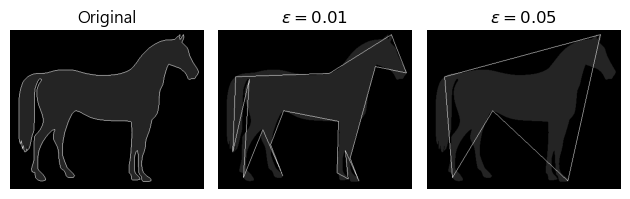

In [42]:
img1 = img_raw.copy().astype('uint8')
img2 = img_raw.copy().astype('uint8')
img3 = img_raw.copy().astype('uint8')

c0 = contours[0]

# 실제 컨투어 라인과의 근사치 설정
epsilon1 = 0.01*cv2.arcLength(c0, True)
epsilon2 = 0.05*cv2.arcLength(c0, True)

# 컨투어, 근사치, 폐곡선 여부를 입력값으로 설정
approx1 = cv2.approxPolyDP(c0, epsilon1, True)
approx2 = cv2.approxPolyDP(c0, epsilon2, True)

image1 = cv2.drawContours(img1, [c0], -1, 7) 
image2 = cv2.drawContours(img2, [approx1], -1, 7)
image3 = cv2.drawContours(img3, [approx2], -1, 7)

titles = ['Original', '$\epsilon=0.01$', '$\epsilon=0.05$']
images = [image1, image2, image3]

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## `Convex Hull`

- 컨투어 포인트를 모두 포함하는 볼록한 외곽선

- isContourConvex() 함수를 통해 이미지의 컨투어가 볼록한지 확인

- convexHull() 함수를 통해 컨투어 포인트를 볼록하게 만들 수 있음

In [43]:
# 컨투어가 볼록한지 여부
cv2.isContourConvex(c0)

False

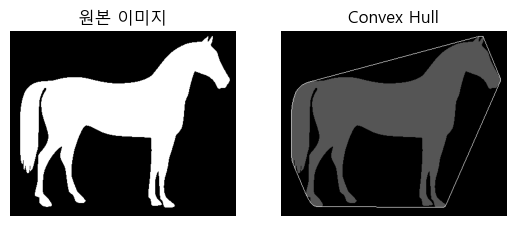

In [44]:
img4 = img_raw.copy().astype('uint8')

c0 = contours[0]
# 컨투어 포인트를 볼록하게
hull = cv2.convexHull(c0)
# 컨투어 정보에서 비트맵 이미지 그리기
image4 = cv2.drawContours(img4, [hull], 0, 3)
titles = ['원본 이미지', 'Convex Hull']
images = [img_raw, img4]

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(titles[i])
    plt.imshow(images[i], 'gray')
    plt.axis('off')

plt.show()

# <span style="color:skyblue"> 4. 이미지 변환 </span>

- 동차좌표 : 2차원 상의 점 위치를 3차원 벡터로 표현하는 방법

- 동차좌표를 활용해 다양한 변환 수행 가능 (이미지를 변환하는 것 : `어파인 변환`)

- 유사변환 : 이미지 확대/축소(s), 회전($\theta$), 이동(t) 가능

- 유사변환의 변환행렬

$H = \begin{bmatrix}scos\theta&-ssin\theta&t_x\\ssin\theta&scos\theta&t_y\\
0&0&1 \end{bmatrix}$

- getRotationMatrix2D() 함수를 통해 변환행렬 생성

```python
getRotationMatrix2D(center, angle, scale)
```

- center : 이미지의 중심 좌표
- angle : 회전시키는 각도 $\theta$ (시계 반대방향)
- scale : 변환하려는 크기 비율 s

In [45]:
# 데이터 불러오기
img_astro = skimage.data.astronaut()
img = cv2.cvtColor(img_astro, cv2.COLOR_BGR2GRAY)
rows, cols = img.shape[:2]

# 이미지의 중심점을 기준으로 30도 회전. 크기는 70%
H = cv2.getRotationMatrix2D((cols/2, rows/2), 30, 0.7)

H

array([[  0.60621778,   0.35      ,  11.20824764],
       [ -0.35      ,   0.60621778, 190.40824764]])

- 변환행렬을 실제로 이미지에 적용해 어파인 변환을 할 때는 warpAffine() 함수 이용

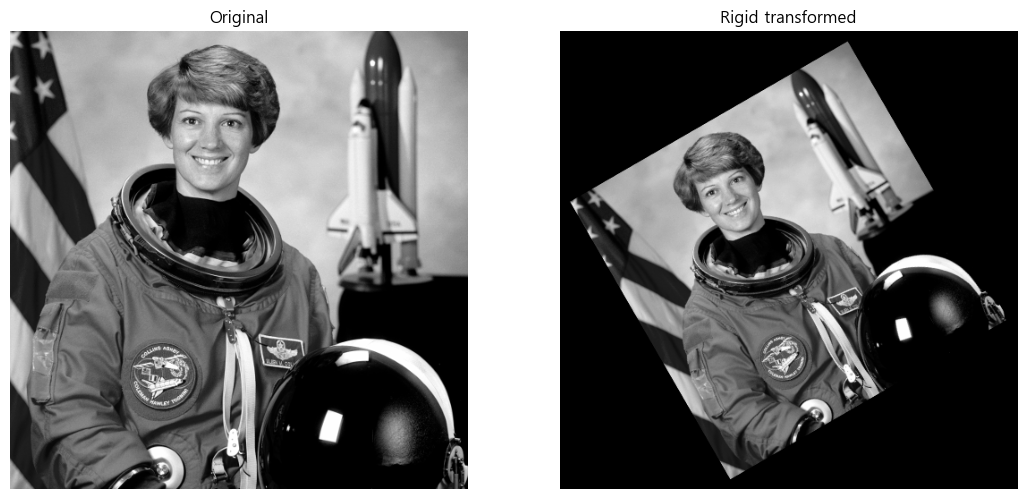

In [46]:
# 앞서 만든 변환행렬 H를 통해 이미지를 어파인 변환
dst = cv2.warpAffine(img, H, (cols, rows))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 13))
ax1.set_title("Original")
ax1.axis("off")
ax1.imshow(img, cmap=plt.cm.gray)
ax2.set_title("Rigid transformed")
ax2.axis("off")
ax2.imshow(dst, cmap=plt.cm.gray)
plt.show()

# <span style="color:skyblue"> 5. 이미지 특징 추출</span>

- 이미지 라인, 코너, 특징점 등의 특징을 추출하는 방법

1. `엣지 추출`

- 엣지 : 이미지 내에서 픽셀 값이 갑자기 변하는 곳

- 이미지를 미분한 그래디언트 벡터의 크기로 엣지를 판단함

- 대표적인 엣지 추출 알고리즘

    - Sobel Edge Detection - Sobel, Laplace : 그래디언트 벡터의 크기 사용
    
    - Canny Edge Detection : 그래디언트 벡터의 크기 + 방향 사용

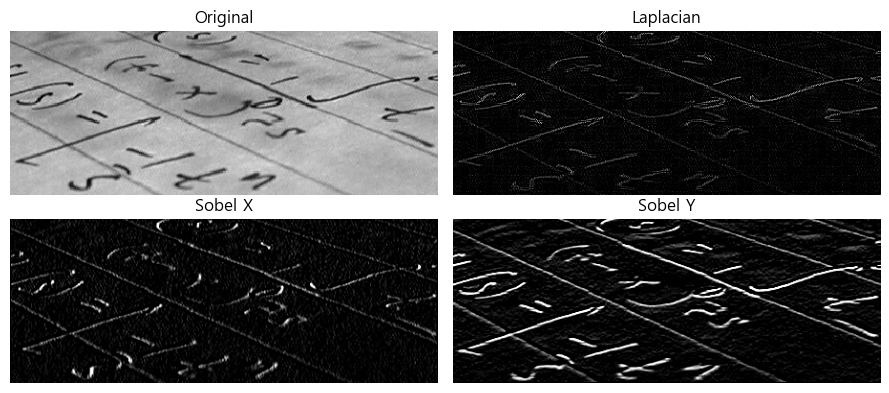

In [47]:
img = text()

# Sobel, Laplace 알고리즘으로 엣지 추출
sobelx = cv2.Sobel(img, cv2.CV_8U, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_8U, 0, 1, ksize=3)
laplacian = cv2.Laplacian(img, cv2.CV_8U)

plt.figure(figsize=(9, 4))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(laplacian, cmap='gray')
plt.title('Laplacian')
plt.axis("off")
plt.subplot(2, 2, 3)
plt.imshow(sobelx, cmap='gray')
plt.title('Sobel X')
plt.axis("off")
plt.subplot(2, 2, 4)
plt.imshow(sobely, cmap='gray')
plt.title('Sobel Y')
plt.axis("off")
plt.tight_layout()
plt.show()

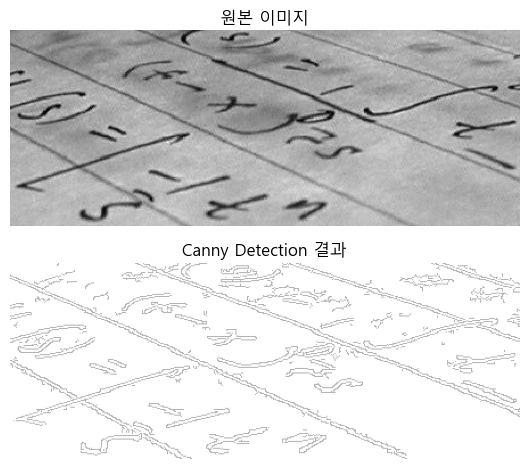

In [48]:
img = text()

# Canny 알고리즘으로 엣지 추출
edges = cv2.Canny(img, 50, 100)

plt.subplot(2, 1, 1)
plt.imshow(img, cmap="gray")
plt.title("원본 이미지")
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(edges, cmap="Greys", alpha=0.3)
plt.axis('off')
plt.title("Canny Detection 결과")
plt.tight_layout()
plt.show()

2. `코너 추출`

- 코너 : 엣지가 교차되는 점

- 대표적인 코너 추출 알고리즘

    - Harris 코너 추출 : 이미지 위에 커널을 이동시키면서 그래디언트의 변화량 계산하고 적절한 기준값으로 구별해 코너점을 찾음 : cornerHarris() 함수 이용
        

    - Tomasi 코너 추출 : 더 작은 변화를 보이는 방향의 변화량이 설정한 기준값보다 크면 코너라고 판단 : goodFeatureToTrack() 함수 이용

     ```python
    goodFeaturesToTrack(image, maxCorners, qualityLevel, minDistance)
    ```

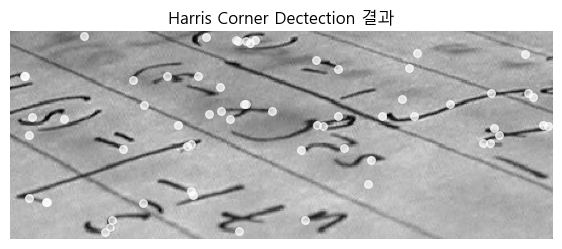

In [49]:
# Harris 코너 추출
dst = cv2.cornerHarris(img, 2, 3, 0.24)

# thresholding
ret, dst = cv2.threshold(dst, 0.001 * dst.max(), 1, 0)

x, y = np.nonzero(dst)

plt.figure(figsize=(7,7))
plt.title("Harris Corner Dectection 결과")
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.scatter(y, x, s=30, c="w", alpha=0.7)
plt.show()

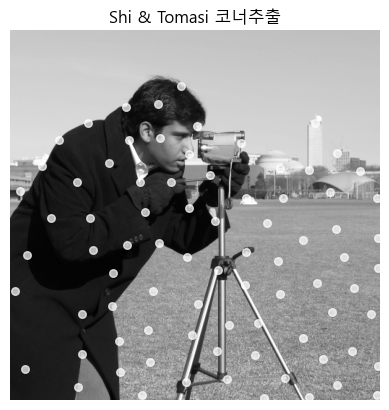

In [53]:
# Tomasi 코너 추출
corners = cv2.goodFeaturesToTrack(img, 100, 0.001, 40)
corners = np.intp(corners)

plt.title("Shi & Tomasi 코너추출")
plt.imshow(img, cmap="gray")
plt.scatter(corners[:, 0, 0], corners[:, 0, 1], s=30, c="w", alpha=0.7)
plt.axis("off")
plt.show()

3. `특징점 추출`

- 대표적인 특징점 추출 알고리즘

    - SIFT (Scale-Invariant Feature Transform) : 특징점의 크기와 각도를 계산해 이미지의 크기가 변하거나 회전해도 동일한 특징점을 찾을 수 있도록 하는 방법
        
    - SURF (Speeded-Up Robust Features) : 인텐서티 계산 방법을 간략화하여 SIFT 방법의 속도와 안정성을 개선한 방법

    - FAST (Features from Accelerated Segment Test)

    - ORB (Oriented FAST and Rotated BRIEF)

3-1. SIFT

In [54]:
from skimage.data import camera
img = camera()

rows, cols = img.shape
H = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 0.7)
img_rotated = cv2.warpAffine(img, H, (cols, rows))
sift = cv2.xfeatures2d.SIFT_create()
kps, des = sift.detectAndCompute(img, None)
kps_r, des_r = sift.detectAndCompute(img_rotated, None)
kp0 = kps[0]
print("pt=({},{}), size={}, angle={}".format(kp0.pt[0], kp0.pt[1], kp0.size, kp0.angle))

pt=(3.8693153858184814,185.40830993652344), size=2.643397092819214, angle=271.9088134765625


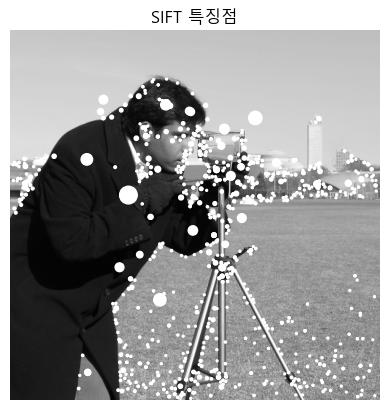

In [55]:
bf = cv2.BFMatcher_create()
matches = bf.knnMatch(des, des_r, k=2)

good = []
for m, n in matches:
    if m.distance < 0.4 * n.distance:
        good.append([m])

np.random.shuffle(good)
image_match = cv2.drawMatchesKnn(
    img, kps, img_rotated, kps_r, good[:10], flags=2, outImg=img)

pts_x = [kp.pt[0] for kp in kps]
pts_y = [kp.pt[1] for kp in kps]
pts_s = [kp.size for kp in kps]

plt.imshow(img, cmap="gray")
plt.title("SIFT 특징점")
plt.axis("off")
plt.scatter(pts_x, pts_y, s=pts_s, c="w")
plt.show()

# <span style="color:skyblue">최종 과제</span>


1. 원하는 사진을 현재 디렉토리에 저장해 열고 그레이스케일로 변환하세요.

- 2.1 이미지 처리 기초

- Hint : Pillow 패키지에서 제공하는 Image 클래스에서 open 메서드를 활용

2. 사진을 180도 회전, 크기는 절반으로 어파인 변환하세요.

- 2.4 이미지 변환

- Hint : getRotationMatrix2D 함수를 통해 변환행렬 생성, warpAffine() 함수를 통해 이미지를 어파인 변환